In [2]:
import osmnx as ox
import networkx as nx
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import matplotlib.pyplot as plt
import numpy as np
import random
import folium

In [3]:
# 1. Obter o mapa da região do Campus Samambaia da UFG
location_point = (-16.6037, -49.2616)  # Coordenadas aproximadas do Campus Samambaia da UFG

# 4 km de raio
radius = 4000

# Obter o grafo da região
G = ox.graph_from_point(location_point, dist=radius, network_type='drive')

In [4]:
# 2. Modelar o grafo
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

#Transforma nós ["A", "B", "C"] em [0, 1, 2]
G = nx.convert_node_labels_to_integers(G)  # Convertendo labels para inteiros
print(G.nodes)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [5]:
# Função auxiliar para extrair coordenadas de um nó
def get_node_coords_graph(G, node):
    point = G.nodes[node]['x'], G.nodes[node]['y']
    return point

def get_node_coords_map(G,node):
    point = G.nodes[node]['y'], G.nodes[node]['x']
    return point

# Resolução do problema de roteamento com rotas aleatórias
def solve_random_vrp(G, num_vehicles, depot):
    nodes = list(G.nodes)
    routes = []
    for _ in range(num_vehicles):
        route_length = random.randint(5, 10)  # Comprimento aleatório da rota
        route = [depot] + random.sample(nodes, route_length) + [depot]
        routes.append(route)
    return routes

# Função para gerar as rotas no grafo
def generate_graph_routes(G, routes):
    graph_routes = []
    for route in routes:
        graph_route = []
        for i in range(len(route) - 1):
            try:
                path = nx.shortest_path(G, source=route[i], target=route[i + 1], weight='length')
                graph_route.extend(path)
            except nx.NetworkXNoPath:
                pass  # Ignora se não houver caminho
        graph_routes.append(graph_route)
    return graph_routes

# Visualização da solução com rotas geradas pelo grafo
def plot_graph_routes(G, routes, depot):
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
    fig, ax = ox.plot_graph(G, show=False, close=False, node_size=0)
    
    for route, color in zip(routes, colors):
        route_nodes = [get_node_coords_graph(G, node) for node in route]
        x, y = zip(*route_nodes)
        ax.plot(x, y, color)
    
    # Destacar o ponto de origem em amarelo
    depot_coords = get_node_coords_graph(G, depot)
    ax.scatter(*depot_coords, c='yellow', s=100, zorder=5)
    
    plt.show()

def plot_single_graph_routes(G, routes, depot):
    colors = ['r','g','b','c','m','y','k']
    depot_coords = get_node_coords_graph(G, depot)

    for route, color in zip(routes, colors):
        route_nodes = [get_node_coords_graph(G, node) for node in route]
        fig, ax = ox.plot_graph(G, show=False, close=False, node_size=0)
        x, y = zip(*route_nodes)
        ax.plot(x, y, color)
        ax.scatter(*depot_coords, c='yellow', s=100, zorder=5)
    
    plt.show(fig)

In [24]:
depot = random.choice(list(G.nodes))  # Seleciona um nó aleatório como ponto de origem
random_routes = solve_random_vrp(G, 3, depot)
graph_routes = generate_graph_routes(G, random_routes)


#Definindo variáveis para salvar as rotas
path_list = []
i = 1

#Por enquanto so mostra a rota, caso queira mostrar os pontos de entrega, descomentar a linha abaixo e definir esses pontos de entrega
points_of_interest_list = []
colors = ["red", "green", "blue", "orange", "purple", "yellow"]
n = folium.Map(location=location_point, zoom_start=14, tiles='cartodbpositron')

for route in graph_routes:
    # Criar um mapa com a rota
    m = folium.Map(location=location_point, zoom_start=14, tiles='cartodbpositron')
    folium.Marker(location=get_node_coords_map(G, depot), popup="Início", colors="green").add_to(m)
    folium.Marker(location=get_node_coords_map(G, depot), popup="Início", colors="green").add_to(n)

    #Indica quantos pontos de interesse aleatórios serão adicionados
    #Para adicionar os pontos de interesse descomente a seguir   
    """for j in range(0,4):
        random_integer = random.choice(route)  
        print(random_integer)
        points_of_interest_list.append(random_integer)
        points_of_interest = get_node_coords_map(G, points_of_interest_list[j])
        folium.Marker(location=points_of_interest,popup=f"Casa do Carlão{j}").add_to(m)"""
        

    for point in graph_routes[i-1]:
        path = get_node_coords_map(G, point)
        path_list.append(path)
    
    color = colors[i % len(colors)]

    folium.PolyLine(path_list, color="green", weight=2.5, opacity=0.8).add_to(m)
    folium.PolyLine(path_list, color=color, weight=2.5, opacity=0.8).add_to(n)
    m.save(f"{i}-rota.html")
    points_of_interest_list.clear()
    path_list.clear()
    i = i + 1

n.save("acompanhando-todas-as-rotas.html")

Nessa Solução Temos 3 percursos, no qual o carro pega a mercadoria faz o percurso e retorna ao local de inicio para pegar novamente a mercadoria e fazer outro percurso

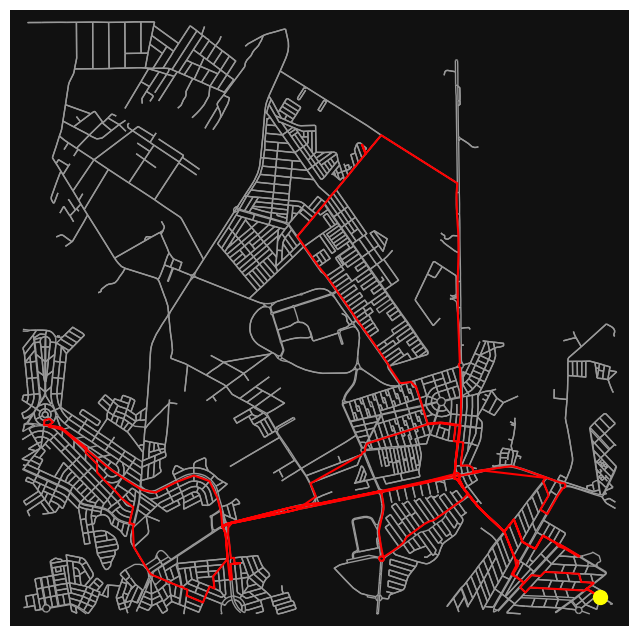

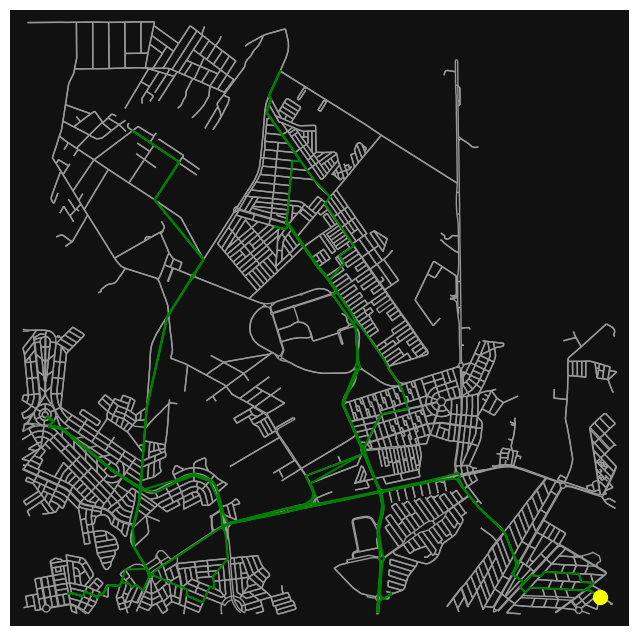

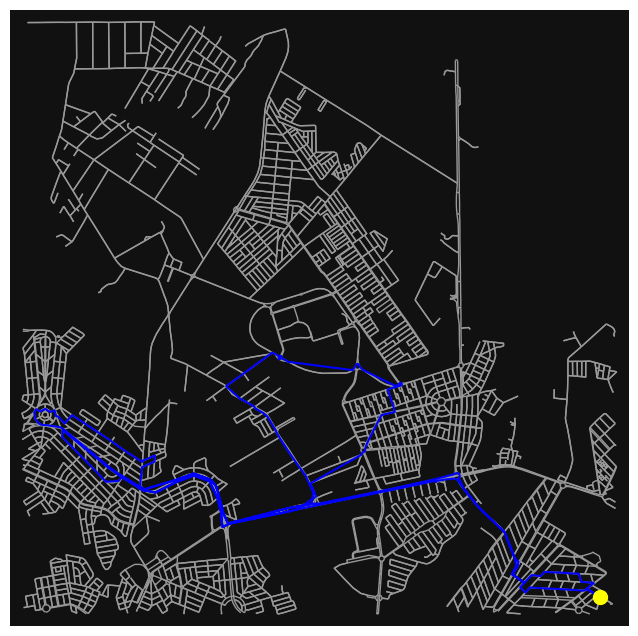

In [71]:
#Gráfico com cada rota separadamente
if graph_routes:
    plot_single_graph_routes(G, graph_routes, depot)
else:
    print("Não foi possível encontrar rotas válidas.")

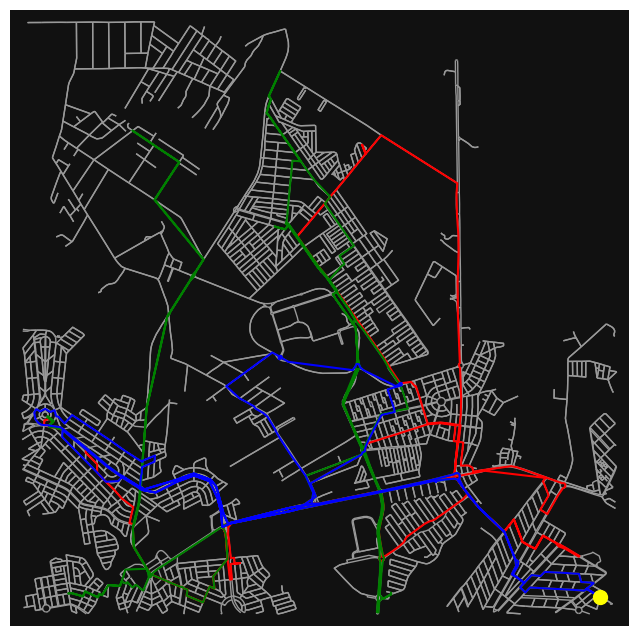

In [72]:
#Gráfico com todas as rotas
if graph_routes:
    plot_graph_routes(G, graph_routes, depot)
else:
    print("Não foi possível encontrar rotas válidas.")